# Watson Assistant Dialog Flow Analysis

<img src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/flow-vis.png" width="70%"> 

## Introduction

This notebook demonstrates the use of visual analytics tools that help you measure and understand user journeys within the dialog logic of your Watson Assistant system, discover where user abandonments take place, and reason about possible sources of issues. The visual interface can also help to better understand how users interact with different elements of the dialog flow, and gain more confidence in making changes to it. The source of information is your Watson Assistant skill definitions and conversation logs.

As described in <a href="https://github.com/watson-developer-cloud/assistant-improve-recommendations-notebook/raw/master/notebook/IBM%20Watson%20Assistant%20Continuous%20Improvement%20Best%20Practices.pdf" target="_blank" rel="noopener noreferrer">Watson Assistant Continuous Improvement Best Practices</a>, you can use this notebook to measure and understand in detail the behavior of users in areas that are not performing well, e.g. having low **Task Completion Rates**.

 
>**Task Completion Rate** - is the percentage of user journeys within key tasks/flows of your virtual assistant that reach a successful resolution. This metric is one of the metrics you can use to measure the **Effectiveness** of your assistant.

  
### Prerequisites 
This notebook assumes some familiarity with the Watson Assistant dialog programming model, such as skills (formerly workspaces), and dialog nodes. Some familiarity with Python is recommended. This notebook runs on Python 3.5.


## Table of contents

1. [Installation and setup](#setup)<br>

2. [Load Assistant Skills and Logs](#load)<br>
    2.1 [Load option one: from a Watson Assistant instance](#load_api)<br>
    2.2 [Load option two: from JSON files](#load_file)<br>
    2.3 [Load option three: from IBM Cloud Object Storage (using Watson Studio)](#load_cos_studio)<br>
    2.4 [Load option four: from custom location](#load_custom)<br>

3. [Extract and transform](#extract_transform)<br>

4. [Visualizing user journeys and abandonments](#dialog_flow)<br>
    4.1 [Visualize dialog flow (turn-based)](#flow_turn_based)<br> 
    4.2 [Visualize dialog flow (milestone-based)](#flow_milestone_based)<br> 
    4.3 [Select conversations at point of abandonment](#flow_selection)<br>

5. [Analyzing abandoned conversations](#analyze_abandonment)<br>
    5.1 [Explore conversation transcripts for qualitative analysis](#transcript_vis)<br>
    5.2 [Identify key words and phrases at point of abandonment](#keywords_analysis)<br>
    5.2.1 [Summarize frequent keywords and phrases](#keywords_analysis_summarize)<br>

6. [Measuring high level tasks of the Assistant](#tasks)<br>

7. [Advanced Topics](#advanced_topics)<br>
    7.1 [Locating important dialog nodes in your assistant](#search)<br>
    7.1.1 [Searching programatically](#search_programatically)<br>
    7.1.2 [Interactive Search and Exploration](#search_visually)<br>
    7.2 [Filtering](#filtering)<br>
    7.3 [Advanced keyword analysis: Comparing abandoned vs. Successful conversations](#keywords_analysis_compare)<br>

8. [Summary and next steps](#summary)<br>

<a id="setup"></a>
## 1. Configuration and Setup

In this section, we install and import relevant python modules. 

<a id="install"></a>
#### Install required Python libraries

In [1]:
# Note, on Watson Studio the pip magic command `%pip` is not supported from within the notebook.  Use !pip instead. 
#!pip install --user conversation_analytics_toolkit
%pip install --user conversation_analytics_toolkit

  Using cached https://files.pythonhosted.org/packages/16/b5/bab3477466a4d9e705d40829ac65683155e7977acbc07f05b06fabded1be/pandas-0.25.3-cp37-cp37m-macosx_10_9_x86_64.whl


Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package words to /Users/aviy/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aviy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aviy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a id="import"></a>
#### 1. Import required modules 

In [3]:
import conversation_analytics_toolkit
from conversation_analytics_toolkit import wa_assistant_skills
from conversation_analytics_toolkit import transformation
from conversation_analytics_toolkit import filtering2 as filtering
from conversation_analytics_toolkit import analysis 
from conversation_analytics_toolkit import visualization 
from conversation_analytics_toolkit import selection as vis_selection
from conversation_analytics_toolkit import wa_adaptor 
from conversation_analytics_toolkit import transcript 
from conversation_analytics_toolkit import flows 
from conversation_analytics_toolkit import keyword_analysis 
from conversation_analytics_toolkit import sentiment_analysis 

import json
import pandas as pd
from pandas.io.json import json_normalize
from IPython.core.display import display, HTML

production-mode detected
version: 1.1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a id="configure"></a>
#### 2. Configure the notebook

In [4]:
# set pandas to show more rows and columns
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)

<a id="load"></a>
## 2. Load Assistant Skills and Logs

<img style="float:right;margin-left: 10px" src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/load.png" width="40%">
The analytics in this notebook are based on two main artifacts: 

1. **Assistant logs** - logs generated from the communication with Watson Assistant via the /message API;
2. **Assistant skill(s)** - the skills that comprise the virtual assistant (aka ["workspace"](https://cloud.ibm.com/apidocs/assistant#get-information-about-a-workspace)).
<br><br>

These artifacts can be loaded from multiple sources, such as directly from Watson Assistant [log](https://cloud.ibm.com/apidocs/assistant#list-log-events-in-a-workspace) or [message](https://cloud.ibm.com/apidocs/assistant#get-response-to-user-input) APIs, or from other locations such as local/remote file system, Cloud Object Storage, or a Database.  

**Note**: below are a set of options to load workspace(s) and log data from different sources into the notebook. Use only **one** of these methods, and then skip to [section 2.2](#organize_skills) 

<a id="load_api"></a>
## 2.1 Load option one: from a Watson Assistant instance

#### 2.1.1 Add Watson Assistant configuration

This notebook uses the Watson Assistant v1 API to access your skill definition and your logs. Provide your Watson Assistant credentials and the workspace id that you want to fetch data from.

You can access the values you need for this configuration from the Watson Assistant user interface. Go to the Skills page and select View API Details from the menu of a skill tile.

- The string to set in the call to `IAMAuthenticator` is your API Key under Service Credentials
- The string to set for version is a date in the format version=YYYY-MM-DD. The version date string determines which version of the Watson Assistant V1 API will be called. For more information about version, see [Versioning](https://cloud.ibm.com/apidocs/assistant/assistant-v1#versioning).
- The string to pass into `service.set_service_url` is the portion of the Legacy v1 Workspace URL that ends with `/api`. For example, `https://gateway.watsonplatform.net/assistant/api`. This value will be different depending on the location of your service instance. Do not pass in the entire Workspace URL.

For Section 2.1.2, the value of `workspace_id` can be found on the same View API Details page. The value of the Skill ID can be used for the workspace_id variable. If you are using versioning in Watson Assistant, this ID represents the Development version of your skill definition.

For more information about authentication and finding credentials in the Watson Assistant UI, please see [Watson Assistant v1 API](https://cloud.ibm.com/apidocs/assistant/assistant-v1) in the offering documentation.

In [5]:
import ibm_watson
from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

authenticator = IAMAuthenticator("<YOUR APIKEY>")
service = AssistantV1(version='2019-02-28',authenticator = authenticator)
service.set_service_url("<YOUR SERVICE URL>")

#### 2.1.2 Fetch and load a workspace
Fetch the workspace for the workspace id given in `workspace_id` variable.

In [ ]:
#select a workspace by specific id
workspace_id = ''
# or fetch one via the APIs
# workspaces=service.list_workspaces().get_result()
# workspace_id = service['workspaces'][0]['workspace_id']

#fetch the workspace
workspace=service.get_workspace(
    workspace_id=workspace_id,
    export=True
).get_result()

# set query parameters
limit_number_of_records=5000
# example of time range query
query_filter = "response_timestamp>=2019-10-30,response_timestamp<2019-10-31"
#query_filter = None
# Fetch the logs for the workspace
df_logs = wa_adaptor.read_logs(service, workspace_id, limit_number_of_records, query_filter)

<a id="load_file"></a>
## 2.2 Load option two: from JSON files

In [7]:
import requests
# this example uses Watson Assistant data sample on github

# pull sample workspace from watson developer cloud
response = requests.get("https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/data/banking-sample/wa-workspace.json").text    
workspace = json.loads(response)

# NOTE: the workspace_id is typically available inside the workspace object.  
# If you've used the `export skill` feature in Watson Assistant UI, you can find the skill id 
# by clicking the `skill`-->`View API details` and copying the value of skill_id  
workspace_id = workspace["workspace_id"] 
#workpace_id = ''

# pull logs sample from watson develop cloud
response = requests.get("https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/data/banking-sample//wa-logs.json").text
df_logs = pd.DataFrame.from_records(json.loads(response))
print("loaded {} log records".format(str(len(df_logs))))

loaded 16883 log records


<a id="load_cos_studio"></a>
## 2.3 Load option three: from IBM Cloud Object Storage (using Watson Studio)

In [ ]:
# @hidden_cell
# The project token is an authorization token that is used by Watson Studio to access project resources. 
# For more details on project tokens, refer to https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html
from project_lib import Project
project = Project(project_id='<replace by Watson Studio project id>', project_access_token='<replace by Watson Studio access token')

workspace_file = "wa-workspace.json"
log_files = "wa-logs.json"

workspace = json.loads(project.get_file(workspace_file))
df_logs = pd.DataFrame.from_records(json.loads(project.get_file(log_files)))

<a id="load_custom"></a>
## 2.4 Load option four: from custom location

In [ ]:
# Depending on your production environment, your logs and workspace files might be stored in different locations.
# such as NoSQL databases, Cloud Object Storage files, etc.

# use custom code here, and make sure you load the workspace as a python dictionary, and the df_logs as a pandas DataFrame.
#workspace = 
#df_logs = 

<a id="extract_transform"></a>
## 3 Extract and Transform  
<img src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/extract-transform.png" width="50%"> 
During this step, relevant information is extracted from the assistant logs, and combined with information from the assistant skills to create single ("canonical") dataframe for the analyses in this notebook.  

**Note**: If your logs are in a custom format or you wish to extract additional fields, you may need to customize the extraction process.  You can learn more about this topic [here](./FAQ.md#canonical-data-model"). 

<a id="organize_skills"></a>
#### Step 1: Prepare skills

Create the **WA_Assistant_Skills** class, to organize relevant workspace objects for the analysis.  The **Extract and Transform** phase will use this class to match the workspace_id column in your logs, and fetch additional relevant information from the skill.  

Call the `add_skill()` function to add relevant workspaces for the analysis.  You can add multiple workspaces that correspond to different versions of a skill, or multiple skills of a **multi-skill** assistant (e.g. if you have your own custom code that routes messages to different dialog skills and want to analyze the collection of skills together)

In [8]:
#if you have more than one skill, you can add multiple skill definitions
skill_id = workspace_id
assistant_skills = wa_assistant_skills.WA_Assistant_Skills()
assistant_skills.add_skill(skill_id, workspace)
#validate the number of workspace_ids
print("workspace_ids in skills: " + pd.DataFrame(assistant_skills.list_skills())["skill_id"].unique())
print("workspace_ids in logs: "+ df_logs.workspace_id.unique())

['workspace_ids in skills: 2da2ab24-aed8-4e58-9398-5726e2f95c47']
['workspace_ids in logs: 2da2ab24-aed8-4e58-9398-5726e2f95c47']


#### Step 2: Extract and Transform  
Call the `to_canonical_WA_v2()` function to perform the extract and transform steps

If your assistant is **multi-skill**, set `skill_id_field="workspace_id"` to link information in the logs, with the corresponding workspace object based on the value of the `workspace_id` attribute in the logs.  

In [9]:
df_logs_canonical = transformation.to_canonical_WA_v2(df_logs, assistant_skills, skill_id_field=None, include_nodes_visited_str_types=True, include_context=False)
#df_logs_canonical = transformation.to_canonical_WA_v2(df_logs, assistant_skills, skill_id_field="workspace_id", include_nodes_visited_str_types=True, include_context=False)

In [10]:
# the rest of the notebook runs on the df_logs_to_analyze object.  
df_logs_to_analyze = df_logs_canonical.copy(deep=False)
df_logs_to_analyze.head(2)

conversation_id                                log_id  \
0  00545e7c-03e3-4074-8105-129dc17b1046  edd0c2cd-50f9-4d3a-8607-d725b3ccf785   
1  007b79e2-a10a-406a-9d71-6f84689e0ac9  b2fbc248-8b84-49d2-8bf4-748d47e9cfef   

                response_timestamp request_text  \
0 2020-02-12 06:12:19.880000+00:00                
1 2020-03-03 14:57:57.172000+00:00                

                             response_text                   nodes_visited  \
0  [Hello, I am the bank's Virtual Agent.]  [Start and Initialize Context]   
1  [Hello, I am the bank's Virtual Agent.]  [Start and Initialize Context]   

  branch_exited branch_exited_reason                              skill_id  \
0  True          completed            2da2ab24-aed8-4e58-9398-5726e2f95c47   
1  True          completed            2da2ab24-aed8-4e58-9398-5726e2f95c47   

  intent_1 intent_1_confidence       event_type intent_1_dialog_triggered  \
0                               REQUEST_REPONSE                             
1                               REQUEST_REPONSE                             

               skill_name                   nodes_visited_str  \
0  Sample_Banking_Chatbot  [Start and Initialize Context[SN]]   
1  Sample_Banking_Chatbot  [Start and Initialize Context[SN]]   

                     turn_label  
0  Start and Initialize Context  
1  Start and Initialize Context

<a id="dialog_flow"></a>
## 4. Visualizing user journeys and abandonments

The dialog flow visualization is an interactive tool for investigating user journeys, visits and abandonments within the steps of the dialog system. 

The visualization aggregates the temporal sequences of steps from Watson Assistant logs.  The interaction allows to explore the distribution of visits across steps and where abandonment takes place, and also select the conversations that visit a certain step for further exploration and analysis.  

You can use the visualization to understand entire end-to-end journeys with the complete log dataset, or you can use filters to focus your exploration on particular journeys or sub-journeys.  

This notebook demonstrates how to construct the visualization at two levels of abstraction
* **turn-based** - for measuring and discovering how conversations progress across every turn in the conversation.
* **milestone-based** - for measuring how conversations progress between key points of interest ("milestones") within the conversation


<img style="float: right;margin: 13px;" src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/turn-flow.png" width="40%"> 
<a id="flow_turn_based"></a>
## 4.1 Visualize dialog flow (turn-based)
Use the `draw_flowchart` function to create a flow-based visualization on the canonical dataset.  By default, the visualization will present the progression of conversations on a turn-by-turn basis, aggregated and sorted by visit sequence frequencies.  You can control many of the default, by modifying the `config` object.  

The following mouse interactions are supported:
* **click** on a node to expand/collapse its children
* **drag** to pan
* **scroll** to zoom in/out

When you hover or click on a node the following information is displayed: 
* **visits:** the number of conversations that progressed along a specific path of conversation steps.
* **drop offs:** the number of conversations that ended at this conversation step 

The examples below demonstrate how to create a turn-based flow analysis: (1) for all conversations in the dataset; and (2) for a subset of conversations that were escalated (denoted by visiting the node **Transfer to Live Agent**)

#### 1. Visualize all conversations
Visualizing all conversations on a turn-by-turn basis can help you to discover all existing conversation flows in your assistant

In [11]:
title = "All Conversations"
turn_based_path_flows = analysis.aggregate_flows(df_logs_to_analyze, mode="turn-based", on_column="turn_label", max_depth=400, trim_reroutes=False)
# increase the width of the Jupyter output cell   
display(HTML("<style>.container { width:95% !important; }</style>"))
config = {
    'commonRootPathName': title, # label for the first root node 
    'height': 800, # control the visualization height.  Default 600
    'nodeWidth': 250, 
    'maxChildrenInNode': 6, # control the number of immediate children to show (and collapse rest into *others* node).  Default 5
    'linkWidth' : 400,  # control the width between pathflow layers.  Default 360     'sortByAttribute': 'flowRatio'  # control the sorting of the chart. (Options: flowRatio, dropped_offRatio, flows, dropped_off, rerouted)
    'sortByAttribute': 'flowRatio',
    'title': title,
    'mode': "turn-based"
}
jsondata = json.loads(turn_based_path_flows.to_json(orient='records'))
visualization.draw_flowchart(config, jsondata, python_selection_var="selection")

<IPython.core.display.Javascript object>

#### 2. Visualize a subset of conversations or conversation steps
Sometime you might want to explore a subset of conversations that meet a certain criteria, or look at the conversations only from a specific point onwards.  The example below shows how to filter conversations that pass through two specific dialog nodes.  

For more details about using filters, please refer to [section 7.2](#filtering)


In [12]:
# filter the conversations that include escalation
title2="Banking Card Escalated"
filters = filtering.ChainFilter(df_logs_to_analyze).setDescription(title2) 
# node with condition on the #Banking-Card_Selection (node_1_1510880732839) and visit the node "Transfer To Live Agent" (node_25_1516679473977)
filters.by_dialog_node_id('node_1_1510880732839')\
       .by_dialog_node_id('node_25_1516679473977')
filters.printConversationFilters() 
# get a reference to the dataframe.  Note: you can get access to intermediate dataframes by calling getDataFrame(index)

In [13]:
filtered_df = filters.getDataFrame()
turn_based_path_flows = analysis.aggregate_flows(filtered_df, mode="turn-based", on_column="turn_label", max_depth=400, trim_reroutes=False)  
config = {
    'commonRootPathName': title2,  'title': title2,
    'height': 800,  'nodeWidth': 250, 'maxChildrenInNode': 6, 'linkWidth' : 400, 'sortByAttribute': 'flowRatio',
    'mode': "turn-based"
}
jsondata = json.loads(turn_based_path_flows.to_json(orient='records'))
visualization.draw_flowchart(config, jsondata, python_selection_var="selection")

<IPython.core.display.Javascript object>

<a id="flow_milestone_based"></a>
## 4.2 Visualize dialog flow (milestone-based)
Use the milestone-based dialog visualization to measure the flow of visits and abandonment between key points of interest (aka "milestones") in your assistant. 

The milestone-based visualization requires two extra steps: 
1. definition of the milestones names, and mapping of which dialog nodes map to each milestone. 
2. processing of the log data to find and filter log rows that are part of a milestone.  

Use the `mode="milestone-based"` to configure the flow aggregation and visualization steps.  The visualization uses a special **Other** node to model conversations that are flowing to other parts of the dialog which were not defined to be of interest in the milestone definitions.  

In this notebook we demonstrate how to produce a milestone dialog flow key points of interest that are part of the **Schedule Appointment** task of the assistant.
 
<img src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/milestone-flow.png" width="80%"> 

#### 1. Define milestones

In [14]:
#define the milestones and corresponding node ids for the `Schedule Appointment` task
milestone_analysis = analysis.MilestoneFlowGraph(assistant_skills.get_skill_by_id(skill_id))

milestone_analysis.add_milestones(["Appointment scheduling start",  "Schedule time", "Enter zip code", "Branch selection", 
                    "Enter purpose of appointment", "Scheduling completion"])

milestone_analysis.add_node_to_milestone("node_21_1513047983871", "Appointment scheduling start")   
milestone_analysis.add_node_to_milestone("handler_28_1513048122602", "Schedule time")
milestone_analysis.add_node_to_milestone("handler_31_1513048234102", "Enter zip code") 
milestone_analysis.add_node_to_milestone("node_3_1517200453933", "Branch selection") 
 
milestone_analysis.add_node_to_milestone("node_41_1513049128006", "Enter purpose of appointment")
milestone_analysis.add_node_to_milestone("node_43_1513049260736", "Scheduling completion")  

#### 2. Derive a new dataset, using enrichment & filtering

In [15]:
#enrich with milestone information - will add a column called 'milestone'
milestone_analysis.enrich_milestones(df_logs_to_analyze)
#remove all log records without a milestone
df_milestones = df_logs_to_analyze[pd.isna(df_logs_to_analyze["milestone"]) == False]
#optionally, remove consecutive milestones for a more simplified flow visualization representation
df_milestones = analysis.simplify_flow_consecutive_milestones(df_milestones)

Processed 3218 conversations..............................................................: : 196it [00:04, 44.27it/s]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              


Removed 1744 duplicate milestone rows


#### 3. Aggregate and visualize 

In [16]:
# compute the aggregate flows of milestones 
computed_flows= analysis.aggregate_flows(df_milestones, mode="milestone-based", on_column="milestone", max_depth=30, trim_reroutes=False)
config = {
    'commonRootPathName': 'All Conversations', # label for the first root node 
    'height': 800, # control the visualization height.  Default 600
    'maxChildrenInNode': 6, # control the number of immediate children to show (and collapse the rest into *other* node).  Default 5
#     'linkWidth' : 400,  # control the width between pathflow layers.  Default 360     '
    'sortByAttribute': 'flowRatio', # control the sorting of the chart. (Options: flowRatio, dropped_offRatio, flows, dropped_off, rerouted)
    'title': "Abandoned Conversations in Appointment Schedule Flow",
    'showVisitRatio' : 'fromTotal', # default: 'fromTotal'.  'fromPrevious' will compute percentages from previous step,
    'mode': 'milestone-based'
}
jsondata = json.loads(computed_flows.to_json(orient='records'))
visualization.draw_flowchart(config, jsondata, python_selection_var="milestone_selection")

<IPython.core.display.Javascript object>

**Note**: The rest of this notebook will demonstrate selection and analysis on selections made in the milestone-based dialog flow (designated by setting the python_selection_var variable to `milestone_selection`. To select and analyze conversations from the turn-based dialog flow, set the variable to `selection` instead).

<a id="flow_selection"></a>
## 4.3 Select conversations at the point of abandonment
<img style="float: right;margin:15px;" src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/abandonment.png" width="40%"> 
Selecting nodes in the visualization enables you to explore and analyze abandoned conversations with a common conversation path. You can use the visualization to identify large volumes of conversations that users abandon at unexpected locations during the conversation.


**Note:**
> Selecting a node in the visualization will also copy the selection from the visualization into the variable designated by `python_selection_var`, thus making the selection available to other cells of this notebook.   

Before you run the next cell, you will interact with the milestone dialog visualization above to select a portion of the dialog to analyze. First, interact with the milestone dialog visualization to observe visit frequencies and abandonments within the milestones of `Schedule Appointment`. Click on nodes to drill down and expand the next step in sequence. Navigate along this path:  `Appointment scheduling start`-->`Schedule time`-->`Enter zip code`-->`Branch selection` to observe a relative high proportion of abandonments that occur in the middle of the flow. Select the `Branch selection` node. Note the large volume and ratio of abandoned conversations. Now run the following cell to process conversations that were abandoned at your point of selection.

In [17]:
#the selection variable contains details about the selected node, and conversations that were abandoned at that point
print("Selected Path: ",milestone_selection["path"])
#fetch the dropped off conversations from the selection  
dropped_off_conversations = vis_selection.to_dataframe(milestone_selection)["dropped_off"]
print("The selection contains {} records, with a reference back to the converstion logs".format(str(len(dropped_off_conversations))))
dropped_off_conversations.head()

Selected Path:  All Conversations\Appointment scheduling start\Schedule time\Enter zip code\Branch selection
The selection contains 700 records, with a reference back to the converstion logs


conversation_id                                log_id
0  00KjvlWcGozRTcSYTrlGqj4JYtYH5gjbvw3j  eggSwGi0knfDhkbKtuvj9fP8cFEVEv3y5XCd
1  082wRLtRsaywE4X6vRqAzd63Ef95nOCmtCZY  Lv9sFTNo0WhNqADDBISitqNVJO6bBzg7gM4X
2  0Aw68rNq6kSGxaDurGG1NSf3c9LtLK3kurWm  gdjVJQIBcHCCCIsZuE0owqYWTQeNSduxIDrb
3  0JeZIbsbHahjag5HZkvWxugqGIxy04Te12ou  x8pA9ZnamaR2ge1jERnx8eU9owpWmhVOpa2e
4  0SoQ9gOlH25dKFePzz4C9DWVLuiWludk1G4L  EPivfOSIGTTMUlkvFPa1EOC0WPKiTj5Zc6hI

<a id="analyze_abandonment"></a>
## 5. Analyzing abandoned conversations
After selecting a large group of abandoned conversations and their corresponding log records, you can apply additional analyses to better understand why these conversations were lost.  

Some possible reasons could be:
* The assistant didn't anticipate or understand the user utterance. This means the dialog skill is not trained to “cover” the user utterance. Coverage is an important measure of how well your assistant is performing. See the [Watson Assistant Continuous Improvement Best Practices](https://github.com/watson-developer-cloud/assistant-improve-recommendations-notebook/raw/master/notebook/IBM%20Watson%20Assistant%20Continuous%20Improvement%20Best%20Practices.pdf) for details on how to measure and improve coverage 
* The options presented to the user were not relevant
* The conversation didn't progress in the right direction
* The assistant’s response wasn't accurate or relevant

This section of the notebook demonstrates two visual components that can help you investigate the user utterances in the abandoned conversations:
* The transcript visualization can show you every user utterance and assistant response until the point of abandonment.
* The key words and phrases analysis can help find frequent terms in abandoned conversations.

<a id="transcript_vis"></a>
## 5.1 Explore conversation transcripts for qualitative analysis
<img style="float: right;margin:13px;" src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/transcript-vis.png" width="50%"> 
The transcript visualization shows the full sequence of conversation steps in the selected group of conversations. You can view the user utterances as well as observe the assistant response and the dialog nodes that were triggered to produce those responses.

Try to navigate to the 3rd conversation (conversation_id == `0Aw68rNq6kSGxaDurGG1NSf3c9LtLK3kurWm`) using the toggle buttons, and scroll down to view the user's last utterance before abandoning the conversation (where user utterance is `wrong map`). In this conversation, the assistant response in the previous step wasn't satisfactory and when the user communicated that to the assistant, the assistant didn't understand his utterance. This may indicate that some modification to the dialog logic might be needed to better respond in this situation, as well as the service itself might need to be fixed.

You might want to check if this situation occurs in other conversations too. A complementary approach is to try to find frequent terms in user utterances and see how prevalent this is across all abandoned conversations (see [next section](#keywords_analysis) for details).

#### Optionally enrich with sentiment information
Adding sentiment will allow you to observe negative utterances more quickly in the transcripts. You can generate other type of analysis insights, by enriching the `insights_tag` column  

In [18]:
df_logs_to_analyze = sentiment_analysis.add_sentiment_columns(df_logs_to_analyze) 
#create insights, and highlights annotation for the transcript visualization
NEGATIVE_SENTIMENT_THRESHOLD=-0.15 
df_logs_to_analyze["insights_tags"] = df_logs_to_analyze.apply(lambda x: ["Negative Sentiment"] if x.sentiment < NEGATIVE_SENTIMENT_THRESHOLD else [], axis=1)
df_logs_to_analyze["highlight"] = df_logs_to_analyze.apply(lambda x: True if x.sentiment < NEGATIVE_SENTIMENT_THRESHOLD else False, axis=1)

In [19]:
# fetch the conversation records
dropped_off_conversations = vis_selection.fetch_logs_by_selection(df_logs_to_analyze, dropped_off_conversations)
# visualize using the transcript visualization 
dfc = transcript.to_transcript(dropped_off_conversations)
config = {'debugger': True} 
visualization.draw_transcript(config, dfc)

<IPython.core.display.Javascript object>

<a id="keywords_analysis"></a>
## 5.2 Identify key words and phrases at point of abandonment

<img style="float: right;" src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/keywords.png" width="30%"> 
The keywords and phrases analysis allows you to check if the phrase `wrong map` is prevalent in many of the abandoned conversations, or what are the most common words or phrases overall.

The analysis performs some basic linguistic processing from a group of utterances, such as removal of stop words, or extraction of the base form of words, and then computes their frequencies. Frequencies for words that appear together in sequence (bi-grams, tri-grams) are also computed.


Finally, the visualization displays the most frequent words and phrases.

#### Gather utterances from abandoned conversations 

In [20]:
# gather user utterances from the dropped off conversations - last utterances and all utterances
last_utterances_abandoned=vis_selection.get_last_utterances_from_selection(milestone_selection, df_logs_to_analyze)
all_utterances_abandoned=vis_selection.get_all_utterances_from_selection(milestone_selection, df_logs_to_analyze)

<a id="keywords_analysis_summarize"></a>
## 5.2.1 Summarize frequent keywords and phrases  
Analyze the last user utterances prior to abandonment to potentially identify common issues at that point.

In [21]:
# analyze the last user input before abandonment
num_unigrams=10
num_bigrams=15
custom_stop_words=["would","pm","ok","yes","no","thank","thanks","hi","i","you"]
data = keyword_analysis.get_frequent_words_bigrams(last_utterances_abandoned, num_unigrams,num_bigrams,custom_stop_words)    

In [22]:
config = {'flattened': True, 'width' : 800, 'height' : 500}
visualization.draw_wordpackchart(config, data)

<IPython.core.display.Javascript object>

**Note**: in the visual above, the term `wrong map` appears quite often.  Other relevant keywords and phrases such as `error`, `map error`, `wrong location`, `wrong branches` are also observed.  

<a id="tasks"></a>
## 6. Measuring high level tasks of the Assistant
<img style="float:right;margin-left: 10px" src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/flow-def.png" width="60%"> 
In some scenarios you might want to first measure the effectiveness of your assistant at key areas within the skill, before drilling into specific flows.  Measuring the volume and effectiveness of specific key areas, can help you detect trends around your release dates, as well as prioritize your improvement efforts.

A conversation can be view and measured as being composed of one or more logical tasks (aka "high level flows"). This section of the notebook demonstrates measuring **transactional tasks** (aka **"flows"**) by defining their corresponding starting (parent) and successful ending dialog nodes.

You can define and measure a task by providing a mapping to dialog nodes that correspond to the start and successful end of a task.

#### 1. Define tasks
<a id="define_tasks"></a>

You can use the programmatic and interactive search options as showed in [section 7.1](#search) to locate and copy corresponding dialog node ids, and use them in the flows definition as shown below.


The example below shows how to define the **Credit card payment** and **Schedule appointments** tasks.  In this example, the starting point was mapped to the node that has a condition on the corresponding intent, and the completion nodes to the nodes that generate the confirmation response.

**Note:**
>Parent and completion nodes can be defined using one or more nodes. Defining multiple parent nodes is useful if a single logical flow is implemented across different branches of the dialog tree. Defining multiple completion nodes can be relevant if you have more than one location in the dialog that can determine successful ending of the flow.

In [23]:
# a flow is defined by a name, one or more "starting/parent_nodes" and one or more "success/completion nodes".   
# All the nodes which are descendants to the parent nodes are considered to be part of the flow
# A flow is considered successful if reaches the completion node
flow_defs_initial = {
  'flows': [{
              'name': 'Credit card payment',
              'parent_nodes': ['node_3_1511326054650'], #condition on #Banking-Billing_Payment_Enquiry || #Banking-Billing_Making_Payments
              'completion_nodes': ['node_8_1512531332315'] # Display of confirmation "Thank you for your payment..." 
            },
            {
              'name': 'Schedule appointment',
              'parent_nodes': ['node_21_1513047983871'], #condition on '#Business_Information-Make_Appointment'
              'completion_nodes': ['node_43_1513049260736'] #Display Appointment Confirmation
            }]
}
#create a list of all the nodes that map to a flow including descendant nodes
flow_defs = flows.enrich_flows_by_workspace(flow_defs_initial, workspace)

#### 2.  Measure task volume and completion rates
<a id="measure_tasks"></a>
Using the task's flow definition and enrichment of the logs, we can now measure the visits in each flow, and the completion percentages.

The **Abandoned** state refers to conversation that terminated in the middle of the flow.  **Rerouted** refers to conversation that left the scope of the flow and didn't return.  **Completed** refers to conversations that successfully reached the completion point.

              flow name  overall  completed  abandoned  rerouted
0  Credit card payment   300      68         179        53      
1  Schedule appointment  1397     450        917        30      


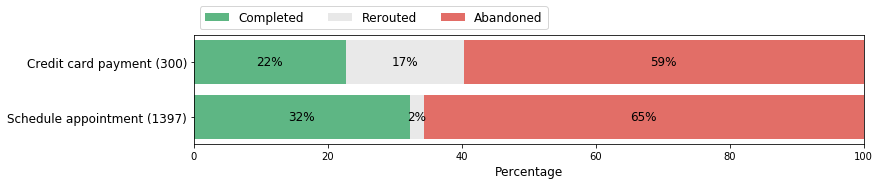

In [24]:
#enrich the logs dataframe with additional columns ["flow", "flow_state"] that represent the state of the flow
df_logs_to_analyze = flows.enrich_canonical_by_flows(df_logs_to_analyze, flow_defs)
flow_outcome_summary = flows.count_flows(df_logs_to_analyze, flow_defs)
print(flow_outcome_summary) 
flows.plot_flow_outcomes(flow_outcome_summary)

**Note**: as shown in above figure, the **Schedule Appointment** task has a relatively large volume of conversations with poor **effectiveness** (as 65% of conversations are abandoned). As a next step you might want to drill down to understand in more detail where exactly in the dialog logic the conversations were abandoned and why.


<a id="advanced_topics"></a>
## 7. Advanced Topics

<a id="search"></a>
## 7.1 Locating important dialog nodes in your assistant

In order to measure the performance of specific tasks, or understand user journeys between specific points of the dialog, you will need to be able to reference dialog nodes by their unique `node_id`.  This section demonstrates how to find the `node_id` of nodes of interest in your dialog using two complementary techniques: a programmatic API, and an interactive visual component.  

<a id="search_programatically"></a>
## 7.1.2 Searching programmatically

The `WA_Assistant_Skills` class provides utility functions for searching dialog nodes in your assistant or in a specific skill.

The `re_search_in_dialog_nodes()` supports a case-insensitive, regular expression-based search.  You can search for strings that appears in the node's title, condition, or id. 

Sample usage of the API:
* `re_search_in_dialog_nodes(search_term)` - search in all fields, in all skills
* `re_search_in_dialog_nodes(search_term, keys=['condition'], in_skill=skill_id)` - search only in condition fields of nodes in specific skill 

Examples of search terms:
* `"card"` - search for a word 
* `"@CC_Types"` - search for an entity
* `"#General_Conversation-VA_State"` - search for an intent
* `'#.*banking.*card'` - search for intent that includes banking and card

In [25]:
# example of searching for all occurences of the word 'Card'
search_term='Card'
results = assistant_skills.re_search_in_dialog_nodes(search_term)
results.head(5)

/Users/aviy/.local/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


skill_id            dialog_node      type  \
0  2da2ab24-aed8-4e58-9398-5726e2f95c47  node_20_1519078912729  standard   
1  2da2ab24-aed8-4e58-9398-5726e2f95c47  node_2_1520827154694   standard   
2  2da2ab24-aed8-4e58-9398-5726e2f95c47  node_7_1520999320489   standard   
3  2da2ab24-aed8-4e58-9398-5726e2f95c47  node_26_1518745042506  standard   
4  2da2ab24-aed8-4e58-9398-5726e2f95c47  node_6_1511490600598   standard   

  title  \
0  NaN    
1  NaN    
2  NaN    
3  NaN    
4  NaN    

                                                                                                                                                   conditions  \
0  #Banking-Switch_Cards                                                                                                                                        
1  #Banking-Activate_Card                                                                                                                                       
2  #Banking-Request_Card_Member_Agreement                                                                                                                       
3  #Banking-Report_Fraudulent_Use || #Banking-Report_Stolen_Card || #Banking-Report_Lost_Card || #Banking-Report_Damaged_Card || #Banking-Report_Expired_Card   
4  #Banking-Replace_Card                                                                                                                                        

   matched_in matched_location  
0  conditions  (16, 20)         
1  conditions  (18, 22)         
2  conditions  (17, 21)         
3  conditions  (57, 61)         
4  conditions  (17, 21)

<img style="float: right;margin: 35px;" src="https://raw.githubusercontent.com/watson-developer-cloud/assistant-dialog-flow-analysis/master/notebooks/images/search.png" width="40%">

<a id="search_visually"></a>
## 7.1.3 Interactive search and exploration 
 
You can use the `draw_wa_dialog_chart()` to visualize the dialog nodes of a specific skill in the same tree layout as in Watson Assistant Dialog Editor.  You can interact with the visualization to navigate to, or search for, a particular node, from which you can copy its `node_id`

In [26]:
workspace = assistant_skills.get_skill_by_id(skill_id)
data = {
    'workspace': workspace
}
config = {}
visualization.draw_wa_dialog_chart(config, data)

<IPython.core.display.Javascript object>

<a id="filtering"></a>
## 7.2 Filtering
You can use a built-in filter to narrow down your log records and focus on specific conversations or journey steps.  There are two types of filters
1. **selection** - filters that select a subset of conversations based on some criteria.  Example of selection filters: `by_dialog_node_id`, `by_dialog_not_node_id`, `by_turn_label`, `by_date_range`, `by_dialog_node_str`, `by_column_values`
2. **selection and trimming** - filters that select a subset of conversations and in addition remove some of the conversation steps before a specific point of interest. This allows you to focus on how conversation journeys progress from that point on.  Example of these filters: `trim_from_node_id`, `trim_from_turn_label` 

You can create a chain of filters to work in sequence to narrow down the log records for specific exploration activities.  

Below is an example of a chained filter that finds conversations that pass through the 'Collect Appointment Data' node during Jan 2020

In [27]:
import datetime
import pytz

filters = filtering.ChainFilter(df_logs_to_analyze).setDescription("Filter: collect Appointment Data during Jan 2020") 
filters.by_dialog_node_id('node_22_1513048049461') #  corresponding to 'Collect Appointment Data' node. 
 
# You can use the search utilities described earlier in the notebook to find this node
# You can also use cf.by_turn_label('Collect Appointment Data') to filter on information in the turn label

start_date = datetime.datetime(2020, 1, 1, 0, 0, 0, 0, pytz.UTC)
end_date = datetime.datetime(2020, 1, 31, 0, 0, 0, 0, pytz.UTC)
filters.by_date_range(start_date,end_date)
filters.printConversationFilters() 

# get a reference to the dataframe.  Note: you can get access to itermediate dataframes by calling getDataFrame(index)
filtered_df = filters.getDataFrame()
print("number of unique conversations in filtered dataframe: {}".format(len(filtered_df["conversation_id"].unique())))

number of unique conversations in filtered dataframe: 111


<a id="keywords_analysis_compare"></a>
## 7.3 Advanced keyword analysis: Comparing abandoned vs. successful conversations
Sometimes looking at the last utterances of the abandoned conversations is not enough to find the **root cause** of a problem.  A more advanced approach is to look also at the conversations that successfully completed the flow, and compare which keywords and phrases, are statistically associated more with the abandoned group, not only for the last utterance before the drop off point, but in general at all the utterances of the conversation.

#### Gather utterances from all conversations that completed the journey on the same flow   

In [28]:
#get the logs of conversations that continue to successful completion
scheduling_completed_filter = filtering.ChainFilter(df_logs_to_analyze).setDescription("Appointement Scheduling flow - Completed") 
scheduling_completed_filter.by_dialog_node_id('node_21_1513047983871')   # started the Appointment Scheduling flow 
scheduling_completed_filter.by_dialog_node_id('node_3_1517200453933')    # passed through the "Branch selection" node
scheduling_completed_filter.by_dialog_node_id('node_43_1513049260736')  # reached the completion node of Scheduling Appointment flow
scheduling_completed_filter.printConversationFilters()

In [29]:
#get the user utterances 
scheduling_completed_df = scheduling_completed_filter.getDataFrame()
all_utterances_completed=scheduling_completed_df[scheduling_completed_df.request_text!=""].request_text.tolist()
print("Gathered {} utterances from {} successful journeys".format(str(len(all_utterances_completed)), 
                                                                  str(len(scheduling_completed_df["conversation_id"].unique()))))

Gathered 4355 utterances from 430 successful journeys


#### Outcome analysis: all utterances prior to abandonment vs completed
Which keywords/phrases are statistically more associated with the **all utterances** in abandoned conversations than with completed ones

In [30]:
num_keywords=25
custom_stop_words=["would","pm","ok","yes","no","thank","thanks","hi","i","you"]
data = keyword_analysis.get_data_for_comparison_visual(all_utterances_abandoned, all_utterances_completed, num_keywords,custom_stop_words)

In [31]:
config = {'debugger': True,  'flattened': True, 'width' : 800, 'height' : 600}
visualization.draw_wordpackchart(config, data)

<IPython.core.display.Javascript object>

**Note**: as shown above when doing an outcome-driven analysis **only** terms that are statistically associated with the dropped off conversations are highlighted, for example `next`, `day`, and `day tomorrow`

<a id="summary"></a>
## 8. Summary and next steps

The analysis presented in this notebook can help you measure the effectiveness of specific tasks/flows within the dialog flows of your assistant skills. The visual components can be used to find large groups of conversations with potentially common issues to improve. The flow analysis can help you discover existing journeys, and focus on specific journey points where many conversations are lost. The transcript and visual keywords/phrases analysis helps you explore those conversations to a greater depth and detect potential issues. 


We suggest the following possible next steps:
- **Identify candidate areas to focus your improvement efforts**
    - Use the filtering and the flow visualization capabilities to focus on low performing flows, and identify high volume of problematic areas (e.g. abandonments)
- **Perform initial assessment of potential issues**
    - Use the transcript visualization and text analysis components to identify a list of potential issues to further narrow down groups of common conversations that require a common solution
        - missing intent or entities
        - existing intent, candidate for more training
        - out of scope, candidate for more training
        - dialog logic (sequence of steps, context, changes to condition, list and order of options,. etc)
        - bot response was not relevant
        - backend/webhook related 
- **Export candidate utterances for expanding the coverage of your intents**
    - Export candidate utterances from selected conversations
    - Upload the utterances as a CSV to Watson Assistant using the [Intent Recommendations](https://cloud.ibm.com/docs/services/assistant?topic=assistant-intent-recommendations#intent-recommendations-log-files-add) feature 
- **Perform detailed analysis to identify the changes needed to the dialog logic**
    - Export a selected group of conversations that require detailed analysis
    - Perform an assessment of the conversations using the provided spreadsheet template
    - Import the assessment spreadsheet to the [Effectiveness Notebook](https://github.com/watson-developer-cloud/assistant-improve-recommendations-notebook/blob/master/notebook/Effectiveness%20Notebook.ipynb) to identify the most commonly occurring problems and prioritize a list of improvement actions
- **Measure change in user journeys after deploying to production**
    - Gain more confidence in making changes, by tracking changes to the flow metrics and user journeys in the dialog flow before and after deploying to production
    - Load data of similar time range from before and after deployment of a new release. Create a separate flow analysis for each time period, and observe expected changes to user journeys that were updated from the last release, and that no negative side-effects impact otherwise stable flows.

For more information, please check <a href="https://github.com/watson-developer-cloud/assistant-improve-recommendations-notebook/raw/master/notebook/IBM%20Watson%20Assistant%20Continuous%20Improvement%20Best%20Practices.pdf" target="_blank" rel="noopener noreferrer">Watson Assistant Continuous Improvement Best Practices</a>.


#### Here are a few useful exports you can use to support above activities

In [32]:
#to export all user utterances in the dropoff point of flow visualization selection  
dropped_off_conversations[dropped_off_conversations["request_text"] != ""].to_csv('abandoned-user-utterances.csv', columns=["request_text"], index=False, header=False)

#to export all user utterances in the dropoff point of flow visualization selection
dropped_off_conversations.to_csv('abandoned-conversation-ids.csv', columns=["conversation_id"], index=False,header=False) 

#to export all columns of the canonical model for abandoned conversations  
dropped_off_conversations.to_csv('abandoned-logs.csv', index=False,)

#to export specific conversation, e.g. 00KjvlWcGozRTcSYTrlGqj4JYtYH5gjbvw3j
conversation_id_to_export = '00KjvlWcGozRTcSYTrlGqj4JYtYH5gjbvw3j'
df_logs_to_analyze[df_logs_to_analyze["conversation_id"] == conversation_id_to_export].to_csv(conversation_id_to_export + ".csv", index=False)

#to export user utterances for intent training with Watson Recommends
from conversation_analytics_toolkit import export
sentences = dropped_off_conversations[dropped_off_conversations["request_text"] != ""].reset_index()
sentences = sentences[["request_text"]]
sentences.columns = ['example']
filtered_sentences = export.filter_sentences(sentences, min_complexity = 3, max_complexity = 20)
df_sentences = pd.DataFrame(data={"training_examples": filtered_sentences})
df_sentences.to_csv("./utterances-for-Watson-Intent-Recommendations.csv", sep=',',index=False, header=False)

### <a id="authors"></a>Authors

**Avi Yaeli** is a Research Staff Member at IBM Research AI organization, where he develops algorithms and tools for discovering insights in complex data. His research interests include data mining, information visualization, natural language processing, and cloud computing. Avi has published more than 30 papers and patents. 

**Sergey Zeltyn**, Ph.D. in Statistics, is a Data Scientist in IBM Research - Haifa. His research agenda includes text analytics, machine learning, forecasting and operations research. Sergey has broad experience in data analysis, model development and implementation. His research has been published at top operations research and statistical journals.

### <a id="acknowledgement"></a> Acknowledgement

The authors would like to thank the following members of IBM Watson, Research and Services for their contributions and feedback of the underlying technology and notebook: Eric Wayne, Zhe Zhang, Kyle Croutwater, David Boaz, Kalyan Dutia, Erika Agostinelli, and Tony Hickman. 

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.